# Assignment 4: Simple GAN Baseline

**Philosophy**: Start simple, add complexity only if needed.

**Key simplifications from CTGAN attempt:**
- MinMax normalization (not VGM modes)
- Simple MLP (no residual blocks, no PAC)
- Standard WGAN-GP with N_CRITIC=5
- Focus on matching distributions correctly

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
import os
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Using device: cuda


## 2. Data Loading

In [2]:
# Load the Adult dataset from ARFF file
data, meta = arff.loadarff('../data/adult.arff')
df = pd.DataFrame(data)

# Decode byte strings
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.decode('utf-8')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


## 3. Simple Preprocessor (MinMax + One-Hot)

In [3]:
# Define feature types
CONTINUOUS_COLS = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
CATEGORICAL_COLS = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country']
TARGET_COL = 'income'

print(f"Continuous: {len(CONTINUOUS_COLS)}, Categorical: {len(CATEGORICAL_COLS)}")

Continuous: 6, Categorical: 8


In [4]:
class SimplePreprocessor:
    """Simple preprocessor: MinMax for continuous, One-Hot for categorical."""
    
    def __init__(self, continuous_cols, categorical_cols, target_col):
        self.continuous_cols = continuous_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col
        self.scaler = MinMaxScaler()
        self.label_encoder = LabelEncoder()
        self.category_mappings = {}
        self.category_dims = {}
        self.mode_values = {}  # For imputation
        
    def fit(self, df):
        df = df.copy()
        
        # Impute missing values with mode
        for col in self.categorical_cols:
            valid = df[df[col] != '?'][col]
            if len(valid) > 0:
                self.mode_values[col] = valid.mode()[0]
                df[col] = df[col].replace('?', self.mode_values[col])
        
        # Fit MinMax scaler on continuous
        self.scaler.fit(df[self.continuous_cols])
        
        # Create category mappings
        for col in self.categorical_cols:
            unique_vals = sorted(df[col].unique())
            self.category_mappings[col] = {v: i for i, v in enumerate(unique_vals)}
            self.category_dims[col] = len(unique_vals)
        
        # Fit label encoder
        self.label_encoder.fit(df[self.target_col])
        
        return self
    
    def transform(self, df):
        df = df.copy()
        
        # Impute missing
        for col in self.categorical_cols:
            if col in self.mode_values:
                df[col] = df[col].replace('?', self.mode_values[col])
        
        # Scale continuous
        continuous = self.scaler.transform(df[self.continuous_cols])
        
        # One-hot encode categorical
        categorical_arrays = []
        for col in self.categorical_cols:
            n_cat = self.category_dims[col]
            onehot = np.zeros((len(df), n_cat))
            for i, val in enumerate(df[col]):
                if val in self.category_mappings[col]:
                    onehot[i, self.category_mappings[col][val]] = 1
            categorical_arrays.append(onehot)
        
        categorical = np.hstack(categorical_arrays)
        
        # Combine
        X = np.hstack([continuous, categorical]).astype(np.float32)
        y = self.label_encoder.transform(df[self.target_col])
        
        return X, y
    
    def get_continuous_dim(self):
        return len(self.continuous_cols)
    
    def get_categorical_dims(self):
        return [self.category_dims[col] for col in self.categorical_cols]
    
    def get_output_dim(self):
        return self.get_continuous_dim() + sum(self.get_categorical_dims())

In [5]:
# Test preprocessor
preprocessor = SimplePreprocessor(CONTINUOUS_COLS, CATEGORICAL_COLS, TARGET_COL)
preprocessor.fit(df)

print(f"Continuous dim: {preprocessor.get_continuous_dim()}")
print(f"Categorical dims: {preprocessor.get_categorical_dims()}")
print(f"Total dim: {preprocessor.get_output_dim()}")

Continuous dim: 6
Categorical dims: [8, 16, 7, 14, 6, 5, 2, 41]
Total dim: 105


## 4. Data Preparation

In [6]:
def prepare_data(df, seed=42, test_size=0.2):
    """Prepare train/test data with stratified split."""
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=seed, stratify=df[TARGET_COL]
    )
    
    preprocessor = SimplePreprocessor(CONTINUOUS_COLS, CATEGORICAL_COLS, TARGET_COL)
    preprocessor.fit(train_df)
    
    X_train, y_train = preprocessor.transform(train_df)
    X_test, y_test = preprocessor.transform(test_df)
    
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Label dist: {np.bincount(y_train) / len(y_train)}")
    
    return X_train, X_test, y_train, y_test, preprocessor

X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, seed=42)

Train: (26048, 105), Test: (6513, 105)
Label dist: [0.75917537 0.24082463]


## 5. Simple GAN Architecture

Key design:
- Generator: MLP with BatchNorm, LeakyReLU
- Discriminator: MLP with Dropout, LeakyReLU
- Softmax for categorical outputs
- Sigmoid for continuous (since scaled to [0,1])

In [7]:
class SimpleGenerator(nn.Module):
    """Simple MLP Generator."""
    
    def __init__(self, latent_dim, continuous_dim, categorical_dims, hidden_dim=256):
        super().__init__()
        self.continuous_dim = continuous_dim
        self.categorical_dims = categorical_dims
        output_dim = continuous_dim + sum(categorical_dims)
        
        self.main = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, z):
        x = self.main(z)
        
        outputs = []
        
        # Continuous: sigmoid to [0, 1]
        continuous = torch.sigmoid(x[:, :self.continuous_dim])
        outputs.append(continuous)
        
        # Categorical: softmax per category
        pos = self.continuous_dim
        for dim in self.categorical_dims:
            cat_logits = x[:, pos:pos+dim]
            # Use Gumbel-softmax for training, softmax for generation
            if self.training:
                # Gumbel-softmax with temperature
                gumbels = -torch.log(-torch.log(torch.rand_like(cat_logits) + 1e-20) + 1e-20)
                y_soft = F.softmax((cat_logits + gumbels) / 0.5, dim=-1)
                # Straight-through
                index = y_soft.max(-1, keepdim=True)[1]
                y_hard = torch.zeros_like(cat_logits).scatter_(-1, index, 1.0)
                cat_out = y_hard - y_soft.detach() + y_soft
            else:
                # Hard one-hot during generation
                index = cat_logits.max(-1, keepdim=True)[1]
                cat_out = torch.zeros_like(cat_logits).scatter_(-1, index, 1.0)
            outputs.append(cat_out)
            pos += dim
        
        return torch.cat(outputs, dim=1)


class SimpleDiscriminator(nn.Module):
    """Simple MLP Discriminator."""
    
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.main(x)

In [8]:
def gradient_penalty(discriminator, real_data, fake_data, device):
    """Standard WGAN-GP gradient penalty."""
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand_as(real_data)
    
    interpolated = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    d_out = discriminator(interpolated)
    
    grads = torch.autograd.grad(
        outputs=d_out,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_out),
        create_graph=True,
        retain_graph=True
    )[0]
    
    grads = grads.view(batch_size, -1)
    return ((grads.norm(2, dim=1) - 1) ** 2).mean()

## 6. Conditional GAN Models

In [9]:
class ConditionalGenerator(nn.Module):
    """Conditional Generator with label embedding."""
    
    def __init__(self, latent_dim, num_classes, continuous_dim, categorical_dims, hidden_dim=256):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.continuous_dim = continuous_dim
        self.categorical_dims = categorical_dims
        output_dim = continuous_dim + sum(categorical_dims)
        
        self.main = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, z, labels):
        # One-hot encode labels
        if labels.dim() == 1:
            labels_onehot = torch.zeros(labels.size(0), self.num_classes, device=z.device)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
        else:
            labels_onehot = labels
        
        x = torch.cat([z, labels_onehot], dim=1)
        x = self.main(x)
        
        outputs = []
        
        # Continuous
        continuous = torch.sigmoid(x[:, :self.continuous_dim])
        outputs.append(continuous)
        
        # Categorical
        pos = self.continuous_dim
        for dim in self.categorical_dims:
            cat_logits = x[:, pos:pos+dim]
            if self.training:
                gumbels = -torch.log(-torch.log(torch.rand_like(cat_logits) + 1e-20) + 1e-20)
                y_soft = F.softmax((cat_logits + gumbels) / 0.5, dim=-1)
                index = y_soft.max(-1, keepdim=True)[1]
                y_hard = torch.zeros_like(cat_logits).scatter_(-1, index, 1.0)
                cat_out = y_hard - y_soft.detach() + y_soft
            else:
                index = cat_logits.max(-1, keepdim=True)[1]
                cat_out = torch.zeros_like(cat_logits).scatter_(-1, index, 1.0)
            outputs.append(cat_out)
            pos += dim
        
        return torch.cat(outputs, dim=1)


class ConditionalDiscriminator(nn.Module):
    """Conditional Discriminator."""
    
    def __init__(self, input_dim, num_classes, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.num_classes = num_classes
        
        self.main = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x, labels):
        if labels.dim() == 1:
            labels_onehot = torch.zeros(labels.size(0), self.num_classes, device=x.device)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
        else:
            labels_onehot = labels
        
        x = torch.cat([x, labels_onehot], dim=1)
        return self.main(x)

## 7. Training Functions

In [10]:
def train_gan(X_train, preprocessor, latent_dim=128, hidden_dim=256,
              batch_size=256, epochs=300, lr_g=0.0002, lr_d=0.0001,
              n_critic=5, lambda_gp=10, dropout=0.3, seed=42,
              save_dir='../outputs/baseline/gan'):
    """Train WGAN-GP."""
    set_seed(seed)
    os.makedirs(save_dir, exist_ok=True)
    
    continuous_dim = preprocessor.get_continuous_dim()
    categorical_dims = preprocessor.get_categorical_dims()
    data_dim = preprocessor.get_output_dim()
    
    generator = SimpleGenerator(
        latent_dim=latent_dim,
        continuous_dim=continuous_dim,
        categorical_dims=categorical_dims,
        hidden_dim=hidden_dim
    ).to(device)
    
    discriminator = SimpleDiscriminator(
        input_dim=data_dim,
        hidden_dim=hidden_dim,
        dropout=dropout
    ).to(device)
    
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9))
    
    dataset = TensorDataset(torch.FloatTensor(X_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    g_losses = []
    d_losses = []
    
    for epoch in tqdm(range(epochs), desc="Training GAN"):
        epoch_g_loss = 0
        epoch_d_loss = 0
        n_batches = 0
        
        for batch_idx, (real_data,) in enumerate(dataloader):
            batch_size_actual = real_data.size(0)
            real_data = real_data.to(device)
            
            # Train Discriminator
            for _ in range(n_critic):
                optimizer_d.zero_grad()
                
                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_data = generator(z)
                
                d_real = discriminator(real_data)
                d_fake = discriminator(fake_data.detach())
                
                gp = gradient_penalty(discriminator, real_data, fake_data.detach(), device)
                d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gp
                
                d_loss.backward()
                optimizer_d.step()
            
            # Train Generator
            optimizer_g.zero_grad()
            
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_data = generator(z)
            d_fake = discriminator(fake_data)
            
            g_loss = -d_fake.mean()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            n_batches += 1
        
        d_losses.append(epoch_d_loss / n_batches)
        g_losses.append(epoch_g_loss / n_batches)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] D: {d_losses[-1]:.4f} G: {g_losses[-1]:.4f}")
    
    return generator, g_losses, d_losses


def train_cgan(X_train, y_train, preprocessor, latent_dim=128, hidden_dim=256,
               batch_size=256, epochs=300, lr_g=0.0002, lr_d=0.0001,
               n_critic=5, lambda_gp=10, dropout=0.3, seed=42,
               save_dir='../outputs/baseline/cgan'):
    """Train Conditional WGAN-GP."""
    set_seed(seed)
    os.makedirs(save_dir, exist_ok=True)
    
    continuous_dim = preprocessor.get_continuous_dim()
    categorical_dims = preprocessor.get_categorical_dims()
    data_dim = preprocessor.get_output_dim()
    num_classes = len(np.unique(y_train))
    
    generator = ConditionalGenerator(
        latent_dim=latent_dim,
        num_classes=num_classes,
        continuous_dim=continuous_dim,
        categorical_dims=categorical_dims,
        hidden_dim=hidden_dim
    ).to(device)
    
    discriminator = ConditionalDiscriminator(
        input_dim=data_dim,
        num_classes=num_classes,
        hidden_dim=hidden_dim,
        dropout=dropout
    ).to(device)
    
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9))
    
    dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    g_losses = []
    d_losses = []
    
    for epoch in tqdm(range(epochs), desc="Training cGAN"):
        epoch_g_loss = 0
        epoch_d_loss = 0
        n_batches = 0
        
        for batch_idx, (real_data, labels) in enumerate(dataloader):
            batch_size_actual = real_data.size(0)
            real_data = real_data.to(device)
            labels = labels.to(device)
            
            # Train Discriminator
            for _ in range(n_critic):
                optimizer_d.zero_grad()
                
                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_data = generator(z, labels)
                
                d_real = discriminator(real_data, labels)
                d_fake = discriminator(fake_data.detach(), labels)
                
                # Gradient penalty for cGAN
                alpha = torch.rand(batch_size_actual, 1, device=device).expand_as(real_data)
                interpolated = (alpha * real_data + (1 - alpha) * fake_data.detach()).requires_grad_(True)
                d_interp = discriminator(interpolated, labels)
                grads = torch.autograd.grad(
                    outputs=d_interp, inputs=interpolated,
                    grad_outputs=torch.ones_like(d_interp),
                    create_graph=True, retain_graph=True
                )[0]
                gp = ((grads.view(batch_size_actual, -1).norm(2, dim=1) - 1) ** 2).mean()
                
                d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gp
                d_loss.backward()
                optimizer_d.step()
            
            # Train Generator
            optimizer_g.zero_grad()
            
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_data = generator(z, labels)
            d_fake = discriminator(fake_data, labels)
            
            g_loss = -d_fake.mean()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            n_batches += 1
        
        d_losses.append(epoch_d_loss / n_batches)
        g_losses.append(epoch_g_loss / n_batches)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] D: {d_losses[-1]:.4f} G: {g_losses[-1]:.4f}")
    
    return generator, g_losses, d_losses

## 8. Data Generation

In [11]:
def generate_synthetic_data(generator, n_samples, latent_dim, device):
    """Generate synthetic data."""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim, device=device)
        synthetic = generator(z)
    return synthetic.cpu().numpy()


def generate_conditional_data(generator, n_samples, latent_dim, label_ratios, device):
    """Generate conditional synthetic data."""
    generator.eval()
    
    samples_per_class = (np.array(label_ratios) * n_samples).astype(int)
    samples_per_class[-1] = n_samples - samples_per_class[:-1].sum()
    
    all_data = []
    all_labels = []
    
    with torch.no_grad():
        for label, n in enumerate(samples_per_class):
            if n > 0:
                z = torch.randn(n, latent_dim, device=device)
                labels = torch.full((n,), label, dtype=torch.long, device=device)
                synthetic = generator(z, labels)
                all_data.append(synthetic.cpu().numpy())
                all_labels.append(np.full(n, label))
    
    return np.vstack(all_data), np.concatenate(all_labels)

## 9. Evaluation Metrics

In [12]:
def compute_detection_metric(X_real, X_synthetic, n_folds=4, seed=42):
    """Detection metric: RF AUC for distinguishing real vs synthetic."""
    y_real = np.zeros(len(X_real))
    y_synthetic = np.ones(len(X_synthetic))
    
    X = np.vstack([X_real, X_synthetic])
    y = np.concatenate([y_real, y_synthetic])
    
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    aucs = []
    
    for train_idx, test_idx in kfold.split(X, y):
        rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
        rf.fit(X[train_idx], y[train_idx])
        proba = rf.predict_proba(X[test_idx])[:, 1]
        aucs.append(roc_auc_score(y[test_idx], proba))
    
    return np.mean(aucs), np.std(aucs)


def compute_efficacy_metric(X_train_real, y_train_real, X_synthetic, y_synthetic,
                           X_test, y_test, seed=42):
    """Efficacy: AUC ratio of synthetic vs real trained model."""
    # Train on real
    rf_real = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_real.fit(X_train_real, y_train_real)
    auc_real = roc_auc_score(y_test, rf_real.predict_proba(X_test)[:, 1])
    
    # Train on synthetic
    rf_synth = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_synth.fit(X_synthetic, y_synthetic)
    auc_synth = roc_auc_score(y_test, rf_synth.predict_proba(X_test)[:, 1])
    
    return auc_synth / auc_real, auc_real, auc_synth

## 10. Plotting

In [13]:
def plot_losses(g_losses, d_losses, title="Training Losses", save_path=None):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator', alpha=0.8)
    plt.plot(d_losses, label='Discriminator', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_distributions(X_real, X_synthetic, preprocessor, n_features=6, 
                       title="Distributions", save_path=None):
    """Compare distributions of continuous features."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    n_cont = preprocessor.get_continuous_dim()
    cols = CONTINUOUS_COLS[:min(n_features, n_cont)]
    
    for i, col in enumerate(cols):
        ax = axes[i]
        ax.hist(X_real[:, i], bins=30, alpha=0.5, label='Real', density=True)
        ax.hist(X_synthetic[:, i], bins=30, alpha=0.5, label='Synthetic', density=True)
        ax.set_title(col)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused axes
    for j in range(len(cols), 6):
        axes[j].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_correlations(X_real, X_synthetic, preprocessor, title="Correlations", save_path=None):
    """Compare correlation matrices."""
    n_cont = preprocessor.get_continuous_dim()
    
    corr_real = np.corrcoef(X_real[:, :n_cont].T)
    corr_synth = np.corrcoef(X_synthetic[:, :n_cont].T)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    names = CONTINUOUS_COLS[:n_cont]
    
    sns.heatmap(corr_real, ax=axes[0], cmap='coolwarm', center=0,
                xticklabels=names, yticklabels=names, annot=True, fmt='.2f')
    axes[0].set_title('Real')
    
    sns.heatmap(corr_synth, ax=axes[1], cmap='coolwarm', center=0,
                xticklabels=names, yticklabels=names, annot=True, fmt='.2f')
    axes[1].set_title('Synthetic')
    
    sns.heatmap(corr_real - corr_synth, ax=axes[2], cmap='coolwarm', center=0,
                xticklabels=names, yticklabels=names, annot=True, fmt='.2f')
    axes[2].set_title('Difference')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## 11. Configuration

In [14]:
# Simple baseline configuration
SEEDS = [42, 123, 456]
LATENT_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 256
EPOCHS = 300
LR_G = 0.0002
LR_D = 0.0001  # TTUR: slower D
N_CRITIC = 5   # Standard WGAN-GP
LAMBDA_GP = 10
DROPOUT = 0.3

os.makedirs('../outputs/baseline/gan', exist_ok=True)
os.makedirs('../outputs/baseline/cgan', exist_ok=True)

print("="*60)
print("SIMPLE BASELINE CONFIGURATION")
print("="*60)
print(f"Latent dim: {LATENT_DIM}")
print(f"Hidden dim: {HIDDEN_DIM}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"LR_G: {LR_G}, LR_D: {LR_D}")
print(f"N_CRITIC: {N_CRITIC}")
print(f"Lambda GP: {LAMBDA_GP}")
print(f"Dropout: {DROPOUT}")
print("="*60)

SIMPLE BASELINE CONFIGURATION
Latent dim: 128
Hidden dim: 256
Batch size: 256
Epochs: 300
LR_G: 0.0002, LR_D: 0.0001
N_CRITIC: 5
Lambda GP: 10
Dropout: 0.3


## 12. Run GAN Experiment


Running Simple GAN with seed 42
Train: (26048, 105), Test: (6513, 105)
Label dist: [0.75917537 0.24082463]


Training GAN:  17%|█▋        | 50/300 [06:52<34:10,  8.20s/it]

Epoch [50/300] D: -0.0084 G: -0.0894


Training GAN:  33%|███▎      | 100/300 [13:47<27:22,  8.21s/it]

Epoch [100/300] D: -0.0014 G: -0.0309


Training GAN:  50%|█████     | 150/300 [20:40<23:33,  9.42s/it]

Epoch [150/300] D: 0.0001 G: -0.0356


Training GAN:  67%|██████▋   | 200/300 [27:33<13:28,  8.08s/it]

Epoch [200/300] D: 0.0053 G: -0.0015


Training GAN:  83%|████████▎ | 250/300 [34:27<06:50,  8.20s/it]

Epoch [250/300] D: 0.0060 G: 0.0077


Training GAN: 100%|██████████| 300/300 [41:06<00:00,  8.22s/it]

Epoch [300/300] D: 0.0036 G: 0.0280


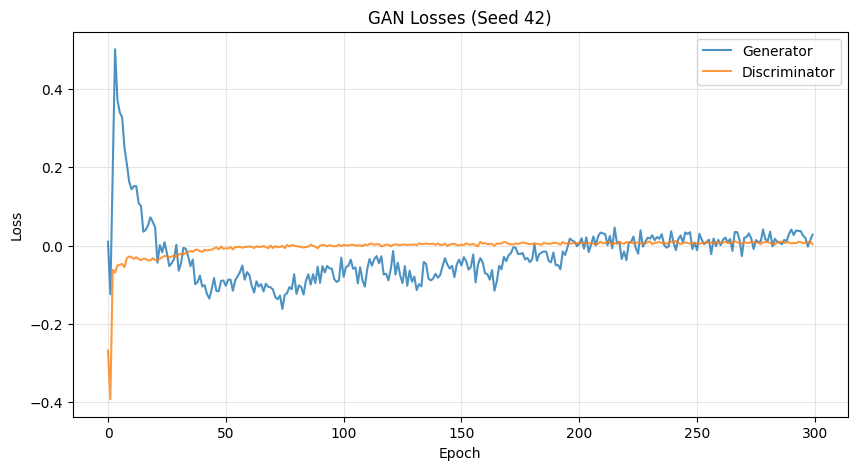


=== DIAGNOSTICS ===
X_train: (26048, 105), range [0.0000, 1.0000]
X_synth: (26048, 105), range [0.0000, 1.0000]
NaN: train=False, synth=False
workclass: real_sum=[1.00,1.00], synth_sum=[1.00,1.00]
education: real_sum=[1.00,1.00], synth_sum=[1.00,1.00]
marital-status: real_sum=[1.00,1.00], synth_sum=[1.00,1.00]


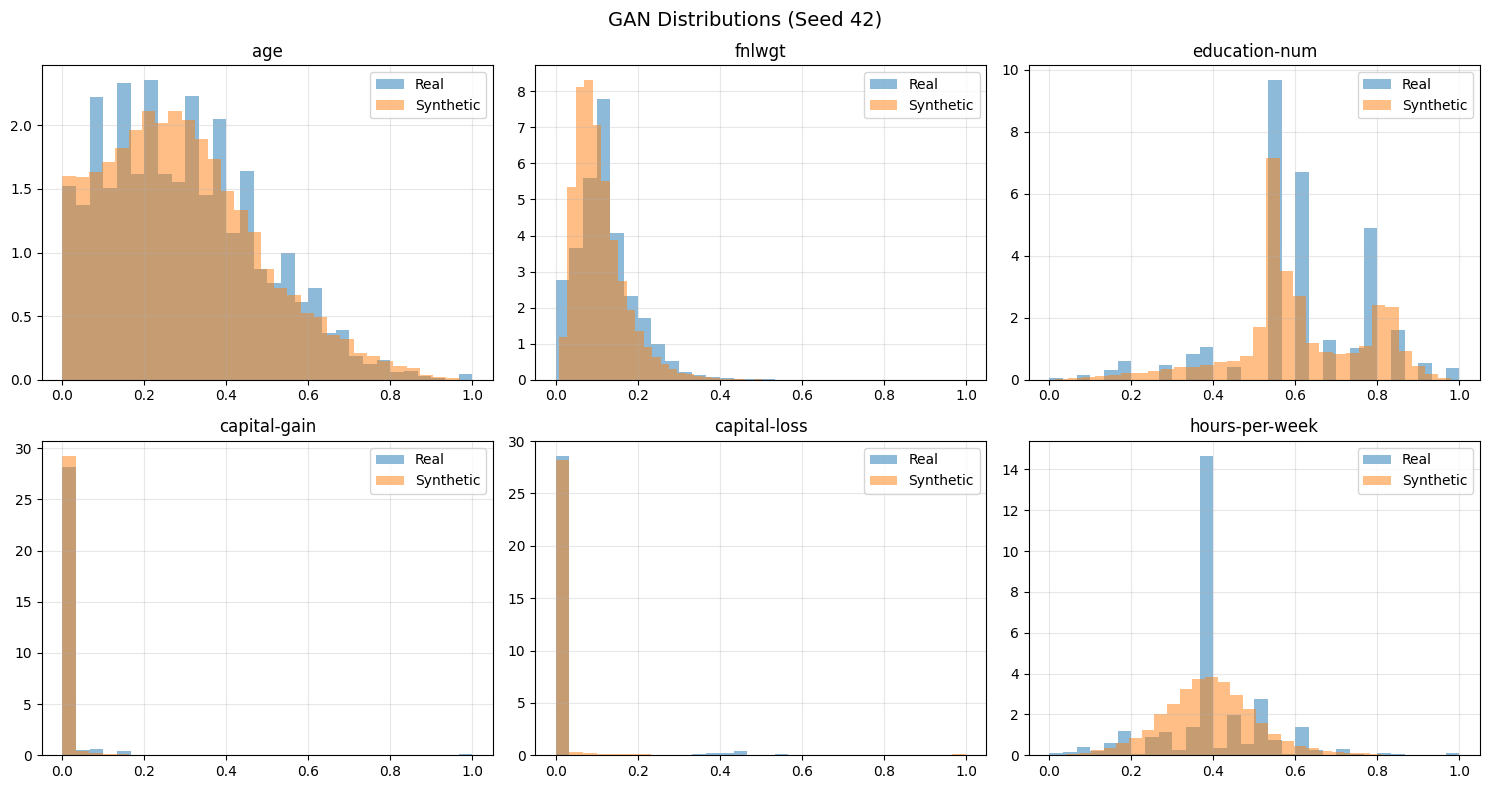

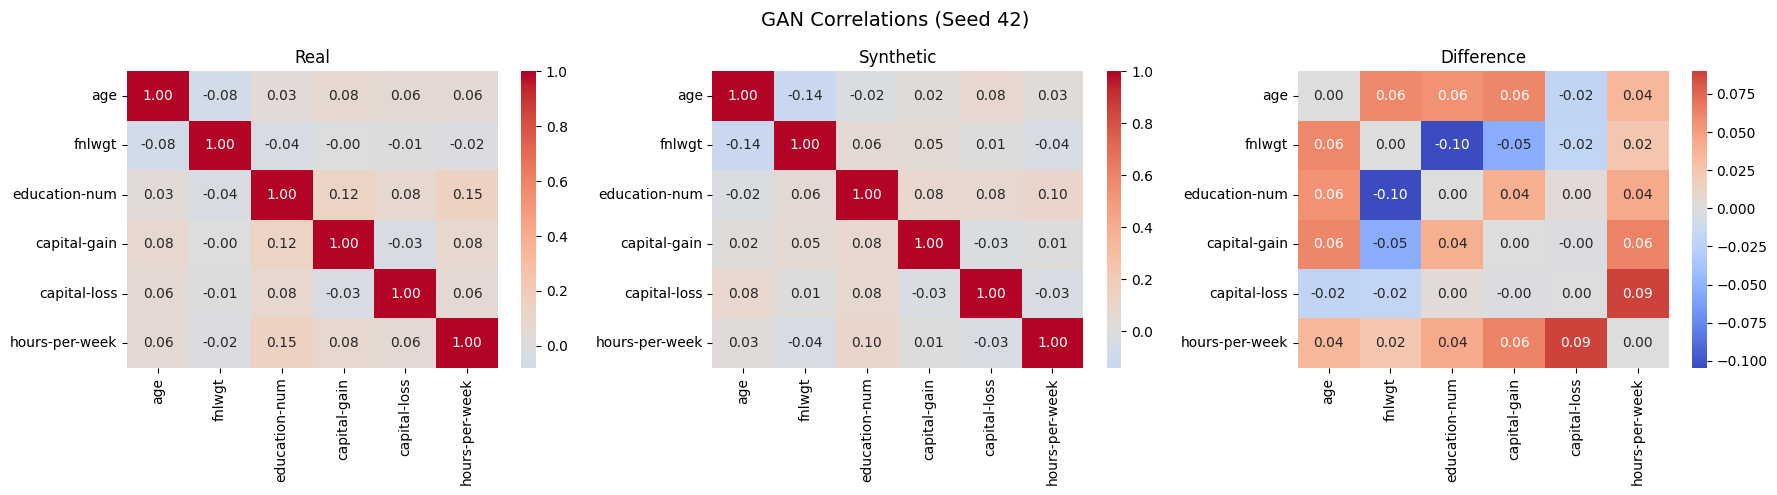


=== GAN Results (Seed 42) ===
Detection AUC: 0.9995 (+/- 0.0001) [target: ~0.5]
Efficacy: 0.6209 [target: ~1.0]
AUC Real: 0.9070, AUC Synth: 0.5631


In [15]:
# Run GAN with seed 42
seed = 42
print(f"\n{'='*60}")
print(f"Running Simple GAN with seed {seed}")
print(f"{'='*60}")

X_train, X_test, y_train, y_test, preprocessor_seed = prepare_data(df, seed=seed)

generator, g_losses, d_losses = train_gan(
    X_train, preprocessor_seed,
    latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    lr_g=LR_G, lr_d=LR_D, n_critic=N_CRITIC,
    lambda_gp=LAMBDA_GP, dropout=DROPOUT, seed=seed
)

# Plot losses
plot_losses(g_losses, d_losses, f"GAN Losses (Seed {seed})",
            f'../outputs/baseline/gan/losses_seed{seed}.png')

# Generate
X_synthetic = generate_synthetic_data(generator, len(X_train), LATENT_DIM, device)
y_synthetic = y_train.copy()

# Diagnostics
print("\n=== DIAGNOSTICS ===")
print(f"X_train: {X_train.shape}, range [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"X_synth: {X_synthetic.shape}, range [{X_synthetic.min():.4f}, {X_synthetic.max():.4f}]")
print(f"NaN: train={np.isnan(X_train).any()}, synth={np.isnan(X_synthetic).any()}")

# Check categorical sums
cont_dim = preprocessor_seed.get_continuous_dim()
cat_dims = preprocessor_seed.get_categorical_dims()
pos = cont_dim
for col, dim in zip(CATEGORICAL_COLS[:3], cat_dims[:3]):
    real_sum = X_train[:, pos:pos+dim].sum(axis=1)
    synth_sum = X_synthetic[:, pos:pos+dim].sum(axis=1)
    print(f"{col}: real_sum=[{real_sum.min():.2f},{real_sum.max():.2f}], "
          f"synth_sum=[{synth_sum.min():.2f},{synth_sum.max():.2f}]")
    pos += dim

# Plots (use keyword arguments)
plot_distributions(X_train, X_synthetic, preprocessor_seed,
                  title=f"GAN Distributions (Seed {seed})",
                  save_path=f'../outputs/baseline/gan/dist_seed{seed}.png')

plot_correlations(X_train, X_synthetic, preprocessor_seed,
                 title=f"GAN Correlations (Seed {seed})",
                 save_path=f'../outputs/baseline/gan/corr_seed{seed}.png')

# Metrics
det_auc, det_std = compute_detection_metric(X_train, X_synthetic, seed=seed)
efficacy, auc_real, auc_synth = compute_efficacy_metric(
    X_train, y_train, X_synthetic, y_synthetic, X_test, y_test, seed=seed
)

print(f"\n=== GAN Results (Seed {seed}) ===")
print(f"Detection AUC: {det_auc:.4f} (+/- {det_std:.4f}) [target: ~0.5]")
print(f"Efficacy: {efficacy:.4f} [target: ~1.0]")
print(f"AUC Real: {auc_real:.4f}, AUC Synth: {auc_synth:.4f}")

## 13. Run cGAN Experiment


Running Simple cGAN with seed 42
Train: (26048, 105), Test: (6513, 105)
Label dist: [0.75917537 0.24082463]


Training cGAN:  17%|█▋        | 50/300 [06:38<33:00,  7.92s/it]

Epoch [50/300] D: -0.0047 G: -0.1691


Training cGAN:  33%|███▎      | 100/300 [13:09<24:55,  7.48s/it]

Epoch [100/300] D: 0.0026 G: -0.1749


Training cGAN:  50%|█████     | 150/300 [19:48<20:35,  8.23s/it]

Epoch [150/300] D: 0.0069 G: -0.1804


Training cGAN:  67%|██████▋   | 200/300 [27:00<14:46,  8.87s/it]

Epoch [200/300] D: 0.0095 G: -0.0788


Training cGAN:  83%|████████▎ | 250/300 [34:03<06:44,  8.09s/it]

Epoch [250/300] D: 0.0079 G: -0.0881


Training cGAN: 100%|██████████| 300/300 [40:39<00:00,  8.13s/it]

Epoch [300/300] D: 0.0088 G: -0.0816


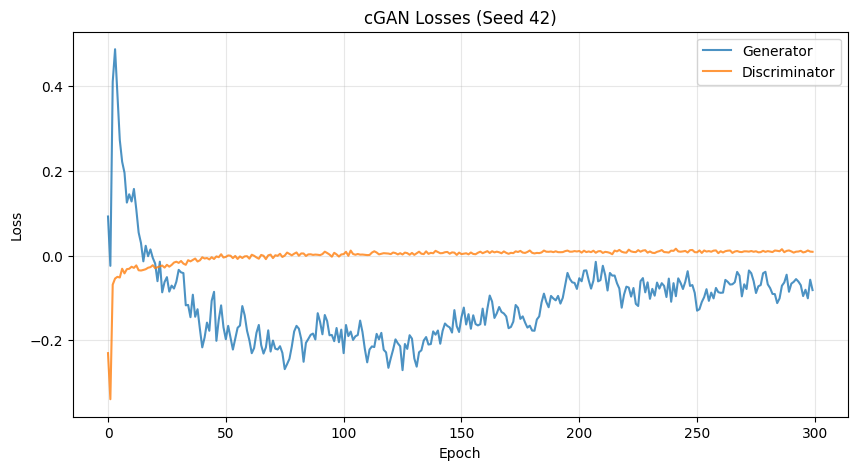

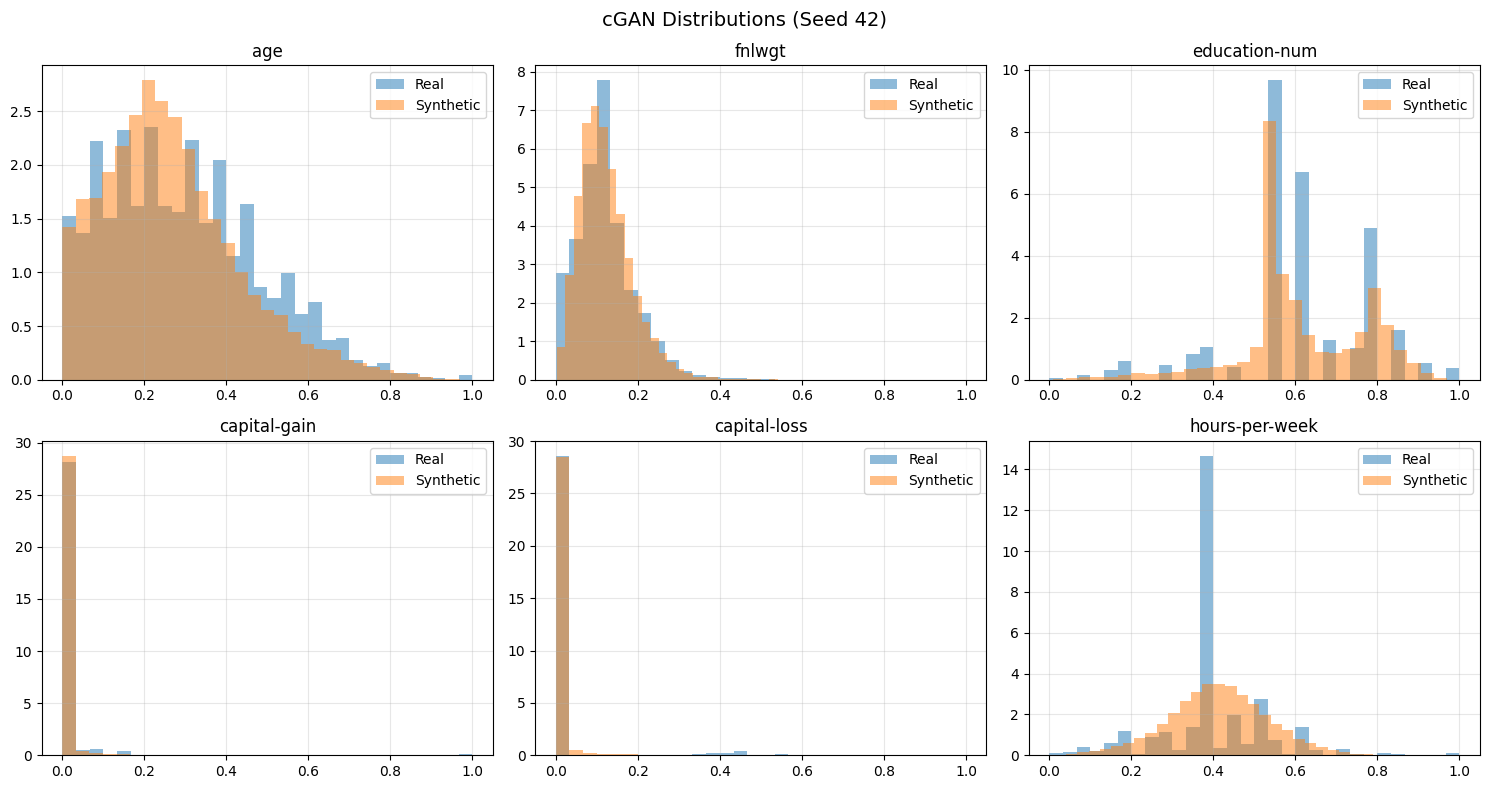

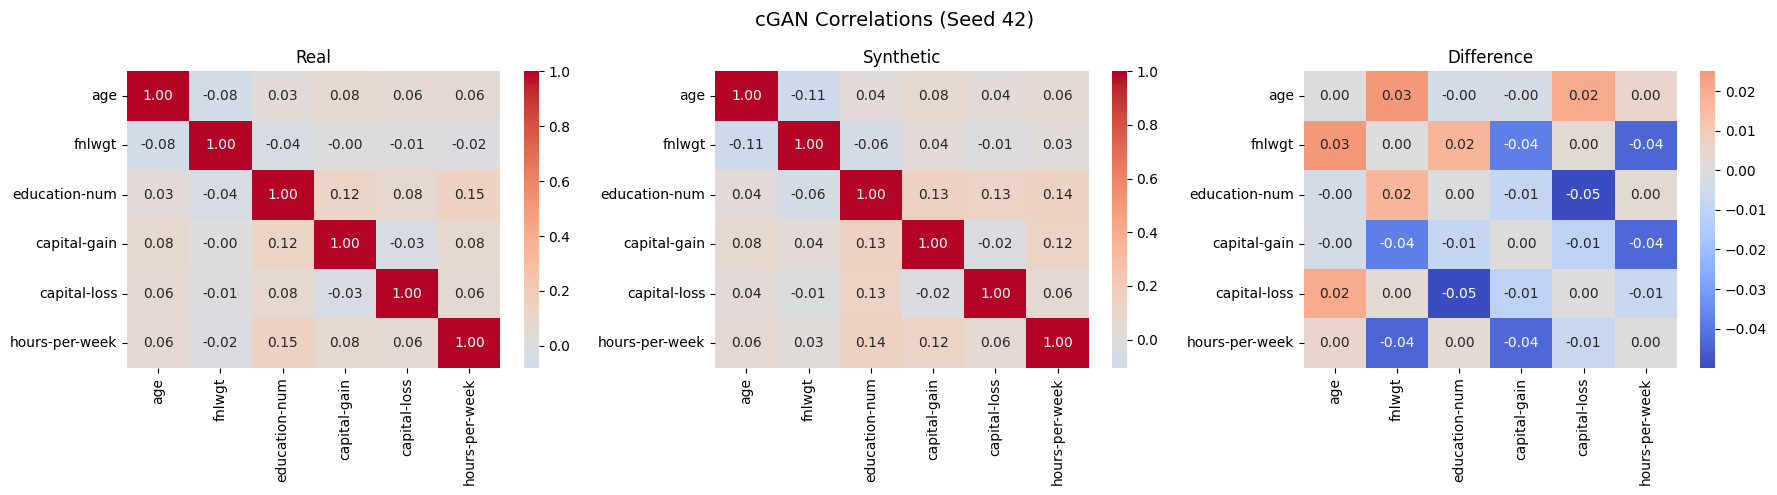


=== cGAN Results (Seed 42) ===
Detection AUC: 0.9997 (+/- 0.0000) [target: ~0.5]
Efficacy: 0.9622 [target: ~1.0]
AUC Real: 0.9070, AUC Synth: 0.8727


In [16]:
# Run cGAN with seed 42
seed = 42
print(f"\n{'='*60}")
print(f"Running Simple cGAN with seed {seed}")
print(f"{'='*60}")

X_train, X_test, y_train, y_test, preprocessor_seed = prepare_data(df, seed=seed)

cgan_gen, cgan_g_losses, cgan_d_losses = train_cgan(
    X_train, y_train, preprocessor_seed,
    latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    lr_g=LR_G, lr_d=LR_D, n_critic=N_CRITIC,
    lambda_gp=LAMBDA_GP, dropout=DROPOUT, seed=seed
)

# Plot losses
plot_losses(cgan_g_losses, cgan_d_losses, f"cGAN Losses (Seed {seed})",
            f'../outputs/baseline/cgan/losses_seed{seed}.png')

# Generate with correct label ratios
label_ratios = np.bincount(y_train) / len(y_train)
X_synth_cgan, y_synth_cgan = generate_conditional_data(
    cgan_gen, len(X_train), LATENT_DIM, label_ratios, device
)

# Plots (use keyword arguments)
plot_distributions(X_train, X_synth_cgan, preprocessor_seed,
                  title=f"cGAN Distributions (Seed {seed})",
                  save_path=f'../outputs/baseline/cgan/dist_seed{seed}.png')

plot_correlations(X_train, X_synth_cgan, preprocessor_seed,
                 title=f"cGAN Correlations (Seed {seed})",
                 save_path=f'../outputs/baseline/cgan/corr_seed{seed}.png')

# Metrics
cgan_det_auc, cgan_det_std = compute_detection_metric(X_train, X_synth_cgan, seed=seed)
cgan_efficacy, cgan_auc_real, cgan_auc_synth = compute_efficacy_metric(
    X_train, y_train, X_synth_cgan, y_synth_cgan, X_test, y_test, seed=seed
)

print(f"\n=== cGAN Results (Seed {seed}) ===")
print(f"Detection AUC: {cgan_det_auc:.4f} (+/- {cgan_det_std:.4f}) [target: ~0.5]")
print(f"Efficacy: {cgan_efficacy:.4f} [target: ~1.0]")
print(f"AUC Real: {cgan_auc_real:.4f}, AUC Synth: {cgan_auc_synth:.4f}")

## 14. Run All Seeds

In [ ]:
# Results storage
all_gan_results = []
all_cgan_results = []

for seed in SEEDS:
    print(f"\n{'='*60}")
    print(f"SEED {seed}")
    print(f"{'='*60}")
    
    X_train, X_test, y_train, y_test, prep = prepare_data(df, seed=seed)
    
    # GAN
    gen, g_l, d_l = train_gan(
        X_train, prep, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
        batch_size=BATCH_SIZE, epochs=EPOCHS, lr_g=LR_G, lr_d=LR_D,
        n_critic=N_CRITIC, lambda_gp=LAMBDA_GP, dropout=DROPOUT, seed=seed
    )
    X_synth = generate_synthetic_data(gen, len(X_train), LATENT_DIM, device)
    y_synth = y_train.copy()
    
    det, _ = compute_detection_metric(X_train, X_synth, seed=seed)
    eff, _, _ = compute_efficacy_metric(X_train, y_train, X_synth, y_synth, X_test, y_test, seed=seed)
    all_gan_results.append({'seed': seed, 'detection': det, 'efficacy': eff})
    print(f"GAN seed {seed}: Det={det:.4f}, Eff={eff:.4f}")
    
    # cGAN
    cgen, cg_l, cd_l = train_cgan(
        X_train, y_train, prep, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
        batch_size=BATCH_SIZE, epochs=EPOCHS, lr_g=LR_G, lr_d=LR_D,
        n_critic=N_CRITIC, lambda_gp=LAMBDA_GP, dropout=DROPOUT, seed=seed
    )
    label_ratios = np.bincount(y_train) / len(y_train)
    X_synth_c, y_synth_c = generate_conditional_data(cgen, len(X_train), LATENT_DIM, label_ratios, device)
    
    cdet, _ = compute_detection_metric(X_train, X_synth_c, seed=seed)
    ceff, _, _ = compute_efficacy_metric(X_train, y_train, X_synth_c, y_synth_c, X_test, y_test, seed=seed)
    all_cgan_results.append({'seed': seed, 'detection': cdet, 'efficacy': ceff})
    print(f"cGAN seed {seed}: Det={cdet:.4f}, Eff={ceff:.4f}")


SEED 42
Train: (26048, 105), Test: (6513, 105)
Label dist: [0.75917537 0.24082463]


Training GAN:  17%|█▋        | 50/300 [06:26<32:03,  7.69s/it]

Epoch [50/300] D: -0.0084 G: -0.0894


Training GAN:  33%|███▎      | 100/300 [12:47<25:26,  7.63s/it]

Epoch [100/300] D: -0.0014 G: -0.0309


Training GAN:  50%|█████     | 150/300 [19:11<19:04,  7.63s/it]

Epoch [150/300] D: 0.0001 G: -0.0356


Training GAN:  67%|██████▋   | 200/300 [25:29<12:38,  7.59s/it]

Epoch [200/300] D: 0.0053 G: -0.0015


Training GAN:  83%|████████▎ | 250/300 [31:46<06:15,  7.51s/it]

Epoch [250/300] D: 0.0060 G: 0.0077


Training GAN:  89%|████████▉ | 268/300 [34:05<04:23,  8.25s/it]

## 15. Final Summary

In [ ]:
print("\n" + "="*60)
print("FINAL RESULTS - SIMPLE BASELINE")
print("="*60)

gan_det = np.mean([r['detection'] for r in all_gan_results])
gan_eff = np.mean([r['efficacy'] for r in all_gan_results])
cgan_det = np.mean([r['detection'] for r in all_cgan_results])
cgan_eff = np.mean([r['efficacy'] for r in all_cgan_results])

print("\nGAN Results (average over 3 seeds):")
print(f"  Detection AUC: {gan_det:.4f} (target: ~0.5)")
print(f"  Efficacy: {gan_eff:.4f} (target: ~1.0)")

print("\ncGAN Results (average over 3 seeds):")
print(f"  Detection AUC: {cgan_det:.4f} (target: ~0.5)")
print(f"  Efficacy: {cgan_eff:.4f} (target: ~1.0)")

print("\nPer-seed results:")
print("\nGAN:")
for r in all_gan_results:
    print(f"  Seed {r['seed']}: Det={r['detection']:.4f}, Eff={r['efficacy']:.4f}")
print("\ncGAN:")
for r in all_cgan_results:
    print(f"  Seed {r['seed']}: Det={r['detection']:.4f}, Eff={r['efficacy']:.4f}")